## Strategy Using Volatility Skew 

In the previous video, we learned about the concept of volatility skew, which is the difference between the implied volatilities of OTM calls and OTM puts at the same distance from an ATM option. Volatility skew can help to predict the future direction of the market. In this notebook, we will create a volatility skew-based trading strategy. We will also calculate and visualise the strategy returns and analyse the strategy's performance.

Volatility skews comes from the fatc that OTM Put worht more than OTM Call becasue investors have a bearish sentimetn about the underlying price, thus the demand for OTM Put rises. Thus the skew can help indicate teh direction of the market. All of that because the IV are diretcly proportional to the prices, amrket sentiment can be gauged throuygh an undertadning of the level of IV.

The most basic and common measure of skew is the first derivative (slope) of implied volatility with respect to strike:

Skew trading is not a bet on absolute volatility, but on relative differences between strikes.

That’s why you can be delta-neutral and still make money — if your prediction about how the skew evolves is correct.


#### The notebook is structured as follows: 
1. [Import Libraries](#libraries)
2. [Read the Data](#read)
3. [Calculate ATM & OTM Strike Price](#calc_strike_price)
4. [Calculate Implied Volatility (IV)](#implied_volatility)
5. [Calculate OTM & ATM IV](#get_iv)
6. [Calculate Volatility Skew](#volatility_skew)
7. [Create Volatility Skew Strategy](#strategy)  
8. [Analyse Strategy Performance](#returns) 
9. [Conclusion](#conclusion) 


<a id='libraries'></a>   
## Import Libraries 

$Skew_{25} = IV_{25} -deltaput - IV_{25-delta call}$

## TODO

Inteoduce the volailtity skew
- Plot the volatility skew, explain where does it come from and why index optiosn have teh highest
- Plot it as for seevral maturity to show it is higehr at lower ones

Add IV Rank and IV Percentile Filters
- Only act when IV rank is moderate (20–80%) to avoid trading into event-driven skew.
- Prevents false positives during earnings, crises, etc.

Vol Surface Modeling
- Fit parametric models to the surface (e.g., SVI or SABR)
- Use fitted surface to detect arbitrage (butterfly or calendar arbitrage violations)

Machine Learning Classification
- Train a model to predict skew reversion vs persistence:
- Features: IVs, skew z-score, vol rank, recent price return, realized vol, VIX
- Labels: did skew revert in next N days?

Trade diretcly the slope of teh skew
- When you believe the skew is too steep and will flatten.
- Use Put Vertical Spread (Bear Put Spread):
	- Sell deeper OTM put (expensive, high IV)
	- Buy closer-to-ATM put (cheaper, lower IV)
- This works well when IV mean-reverts or fear subsides.
- Skew as a slope: $\text{Skew} = \frac{d \, \text{IV}(K)}{dK} \approx \frac{\text{IV}{K_2} - \text{IV}{K_1}}{K_2 - K_1}$ (FDM)

Use delta for bet on relative change in skew between OTM puts and calls
- 25-Delta Skew (Risk Reversal Skew): $Skew_{25} = IV_{25-deltaput} - IV_{25-delta call}$
- If put skew is overpriced, you can (SAME DELTA):
	- Sell OTM put (e.g a delta of 25∆)
	- Buy OTM call (e.g a delta 25∆)
- Delta is ~neutral, and the position profits if puts cheapen vs. calls (skew flattens or inverts).
- This is a pure skew trade with limited exposure to vol level

Add other trading signals
- Use zcore instead of absoulute threshold values (possibly usign rolling zcore)
- Introduce a time based exit signals (5 days exit if trade does not occur)
- Introduce stop loss exit signal (if after enterign teh tarde we lose x%)
- Inteoduce etchncial analysis signals (RSI) for entering exiting the trade
- Can use a forecast based appraoch to time the entry/exit

Skew vs RV skew: implied skew vs realized skew of returns
- Compare implied skew to realized skew of returns:
	- Implied Skew (IV Skew) $\text{IV Skew} = \text{IV}{\text{put (25Δ)}} - \text{IV}{\text{call (25Δ)}}$
	- Realized skew = 3rd standardized moment of past returns: $\text{Skewness} = \frac{E[(r - \bar{r})^3]}{\sigma^3}$
- When both are aligned, skew pricing is justified
- When both are different (IV SKeW >> 0 and RS = 0) market is overpricing crask risk -> sell put (do the opposite for IV Skew =0 and RS >>0)

Backtesting
- Can optimize the entry and exit threshold


In [9]:
# For data manipulation
import pandas as pd
import numpy as np

# To calculate implied volatility
import mibian

# For plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

# Ignore warnings
import warnings 
warnings.filterwarnings('ignore')

<a id='read'></a>
## Read the Data 

The Nifty futures and options data for both call and put options is stored in CSV files, `nifty_futures_data_2022.csv` and `nifty_options_data_2022.csv`, respectively. The data covers the period from January 2022 to May 2022. You can download this data from the last unit of this course '**Python Codes and Data**'.

In [10]:
# Read the futures data
futures_data = pd.read_csv(
    'data_modules/nifty_futures_data_2022.csv', index_col=0)

# Convert the date fields into pandas datetime object
futures_data.index = pd.to_datetime(futures_data.index)
futures_data.Expiry = pd.to_datetime(futures_data.Expiry)

# Calculate the days to expiry
futures_data['days_to_expiry'] = (
    futures_data['Expiry'] - futures_data.index).dt.days

futures_data

,futures_close,Expiry,days_to_expiry
Date,,,
2022-01-03,17677.95,2022-01-27,24
2022-01-04,17846.75,2022-01-27,23
2022-01-05,17960.95,2022-01-27,22
2022-01-06,17788.65,2022-01-27,21
2022-01-07,17854.30,2022-01-27,20
...,...,...,...
2022-05-20,16253.25,2022-05-26,6
2022-05-23,16183.35,2022-05-26,3
2022-05-24,16104.70,2022-05-26,2


In [11]:
# Read the options data
options_data = pd.read_csv(
    'data_modules/nifty_options_data_2022.csv', index_col=0)

# Convert the date fields into pandas datetime object
options_data.index = pd.to_datetime(options_data.index)
options_data.Expiry = pd.to_datetime(options_data.Expiry)

# Display the top 5 rows
options_data

,Expiry,Option Type,Strike Price,Last
Date,,,,
2022-01-03,2022-01-27,CE,15650,1507.70
2022-01-03,2022-01-27,CE,15700,1712.20
2022-01-03,2022-01-27,CE,15750,1834.65
2022-01-03,2022-01-27,CE,15800,1495.00
2022-01-03,2022-01-27,CE,15850,0.00
...,...,...,...,...
2022-05-26,2022-05-26,PE,17950,1939.80
2022-05-26,2022-05-26,PE,18000,1833.90
2022-05-26,2022-05-26,PE,18050,1885.00


<a id='calc_strike_price'></a>
# Calculate ATM & OTM Strike Price

To calculate the volatility skew, we need to perform the following three steps:

1. Calculate ATM strike price 
2. Calculate OTM call and OTM put strike prices 
3. Calculate implied volatilities
<br>

### Calculate ATM Strike Price

The ATM strike price is the nearest strike price to the market price of the underlying security. The underlying security that we have considered here is the Nifty futures. Therefore, we will calculate the ATM strike price with respect to the futures close price. For Nifty, the strike difference is 50. We will set the ATM strike price which is a multiple of 50 and is closest to the futures close price. 

This can be achieved by using the following formula: 

$$ \textrm{ATM strike price} = \textrm{Strike difference}*\textrm{round}\textrm(\frac{\textrm{Market price of the underlying security}}{\textrm{Strike difference}})$$

<br>

Let's take an example to understand this. Let's assume that the strike price of Nifty futures on a given day is 10960.55. The ATM strike price will be calculated as follows: 

$$ \textrm{ATM strike price} = \textrm{50}*\textrm{round}\textrm(\frac{\textrm{10960.55}}{\textrm{50}}) = \textrm{10950}$$


### Calculate OTM Call and OTM Put Strike Prices

We will calculate the OTM call and OTM put strike prices at the same distance from the ATM strike price. We will go 100 points above the ATM strike price to calculate the OTM call strike price, and we will go 100 points below the ATM strike price to calculate the OTM put strike price. 

Note: We have taken 100 points for illustration purposes. You can tweak this value as per your own requirements as well. However, it is recommended to stay close to the ATM strike price. 

In [12]:
# Strike difference for nifty
strike_difference = 50

# Calculate ATM strike price
futures_data['atm_strike_price'] = strike_difference * \
    round(futures_data['futures_close']/strike_difference)

# Calculate OTM call strike price
futures_data['otm_call_strike_price'] = futures_data.atm_strike_price + \
    strike_difference*2

# Calculate OTM put strike price
futures_data['otm_put_strike_price'] = futures_data.atm_strike_price - \
    strike_difference*2

# Display top 5 rows
futures_data.head()

,futures_close,Expiry,days_to_expiry,atm_strike_price,otm_call_strike_price,otm_put_strike_price
Date,,,,,,
2022-01-03,17677.95,2022-01-27,24,17700.0,17800.0,17600.0
2022-01-04,17846.75,2022-01-27,23,17850.0,17950.0,17750.0
2022-01-05,17960.95,2022-01-27,22,17950.0,18050.0,17850.0
2022-01-06,17788.65,2022-01-27,21,17800.0,17900.0,17700.0
2022-01-07,17854.30,2022-01-27,20,17850.0,17950.0,17750.0


<a id='implied_volatility'></a>
## Calculate Implied Volatility (IV)

To calculate the IV, we will use the `impliedVolatility` function of the BS (Black Scholes) class in the `mibian` library. You can check the documentation of the `mibian` library <a href='https://github.com/yassinemaaroufi/MibianLib/blob/master/README' target="_blank">here</a>. 

The syntax for the `mibian` Black Scholes function is:

```python
mibian.BS([underlyingPrice, strikePrice, interestRate, daysToExpiration], callPrice=y, putPrice=z)
```
Parameters: 

* underlyingPrice: It is the price of the underlying security. We will take the Nifty futures close price.
* strikePrice: Strike price of the option. 
* interestRate: Since we will take the futures price and not the spot price as the underlying price, the interest rate will be zero.
* daysToExpiration: Number of days left to expiry of the option contract.
* callPrice: Price of the call option. 
* putPrice: Price of the put option. 
        
Let's define a function to calculate the implied volatility. If the days to expiry are 0 or the last traded price is 0, then the value of IV will be 0. We will check the `Option Type` and pass the appropriate parameters to calculate the IV of call and put options.

In [13]:
# Function to calculate the IV
def calculate_IV(daily_data):

    # Return IV equals 0 if days to expiry is 0 or the last traded price is 0
    if daily_data.days_to_expiry == 0 or daily_data.Last == 0:
        return 0

    # Calculate the IV for call option
    elif daily_data['Option Type'] == 'CE':
        return mibian.BS([daily_data['futures_close'], daily_data['Strike Price'], 0,
                          daily_data['days_to_expiry']], callPrice=daily_data['Last']).impliedVolatility

    # Calculate the IV for put option
    elif daily_data['Option Type'] == 'PE':
        return mibian.BS([daily_data['futures_close'], daily_data['Strike Price'], 0,
                          daily_data['days_to_expiry']], putPrice=daily_data['Last']).impliedVolatility

<a id='get_iv'></a>
## Calculate OTM & ATM IV 

We will define a function `get_IV` that will take the `options_data`, `futures_data` and `strike_price_col_name` as inputs. We will perform the following steps: 

1. We will merge `futures_data` and `options_data` into a single dataframe `data`. This new dataframe will contain data of options contracts where the `Strike Price` is equal to `strike_price_col_name`. 
<br>

2. We will calculate the IV using the `calculate_IV` function defined earlier and add the IV values to the `IV` column of the dataframe `data`. 
<br>

3. For the ATM strike price, we will have two IV values for a single day. One for the call option and the other for the put option. Therefore, we will take the mean of the IV values of the call and put options to get a single IV value for a given day. This is achieved by using the `groupby()` function. 

In [14]:
def get_IV(options_data, futures_data, strike_price_col_name):

    # Merge the dataframes
    data = pd.merge(options_data, futures_data, left_on=['Date', 'Strike Price', 'Expiry'], right_on=[
                    'Date', strike_price_col_name, 'Expiry'], suffixes=('_options', '_futures'))

    # Add IV values to the dataframe
    data['IV'] = data.apply(calculate_IV, axis=1)

    # Calculate the mean of IV values
    return data.groupby('Date').IV.mean().replace(to_replace=0, method='ffill')

In [15]:
# Calculate OTM call IV
print('Calculating OTM Call IV......')
futures_data['OTM_Call_IV'] = get_IV(options_data.loc[options_data['Option Type'] == 'CE'],
                                     futures_data, 'otm_call_strike_price')

# Calculate OTM put IV
print('Calculating OTM Put IV......')
futures_data['OTM_Put_IV'] = get_IV(options_data.loc[options_data['Option Type'] == 'PE'],
                                    futures_data, 'otm_put_strike_price')

# Calculate ATM IV
print('Calculating ATM IV......')
futures_data['ATM_IV'] = get_IV(options_data, futures_data, 'atm_strike_price')

# Display the last three columns of the dataframe
futures_data.iloc[:,-3:].head()

Calculating OTM Call IV......
Calculating OTM Put IV......
Calculating ATM IV......


,OTM_Call_IV,OTM_Put_IV,ATM_IV
Date,,,
2022-01-03,15.008450,15.083313,15.144348
2022-01-04,14.320374,14.381409,14.417648
2022-01-05,13.658524,15.647888,14.990330
2022-01-06,16.010284,16.250610,16.529560
2022-01-07,14.648438,15.632629,15.043259


<a id='volatility_skew'></a>
## Calculate Volatility Skew

The volatility skew is the difference between the implied volatilities of OTM calls and OTM puts at the same distance from an ATM option. It is calculated by using the following formula: 

$$ \textrm{Volatility Skew} = \textrm(\frac{\textrm{IV of OTM Puts - IV of OTM Calls}}{\textrm{ATM IV}})$$

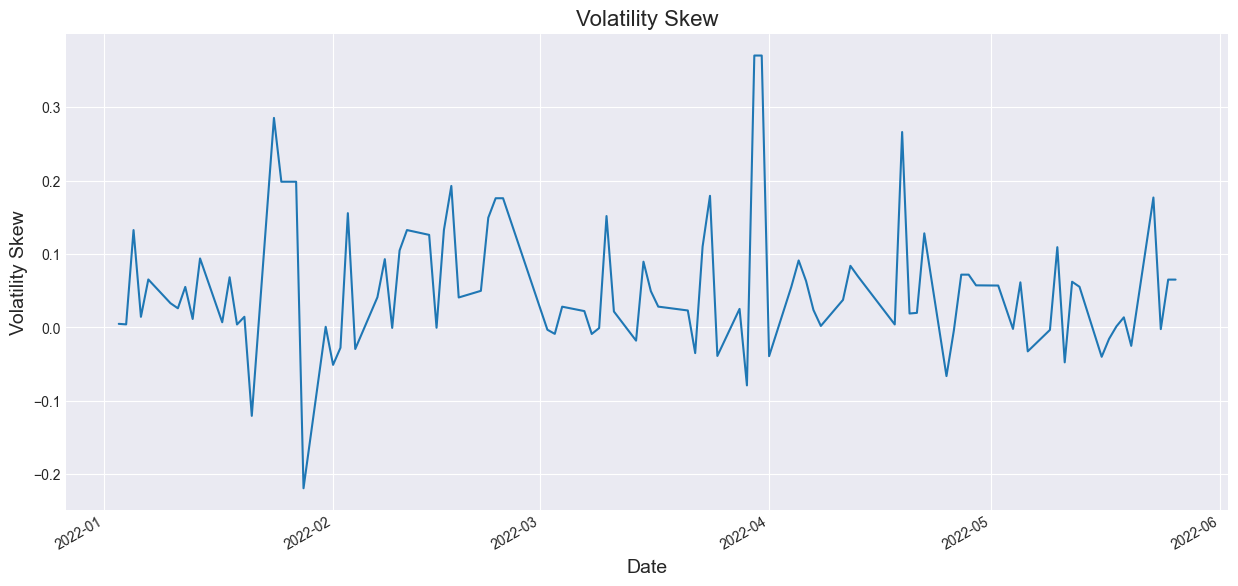

In [16]:
# Calculate volatility skew
futures_data['volatility_skew'] = (
    futures_data.OTM_Put_IV - futures_data.OTM_Call_IV)/futures_data.ATM_IV

# Set figure size
plt.figure(figsize=(15, 7))

# Plot volatility skew
futures_data['volatility_skew'].plot()

# Set the title and axis labels
plt.title('Volatility Skew', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Volatility Skew', fontsize=14)

# Display the chart
plt.show()

If the value of volatility skew is positive, it implies that the IV of OTM put is greater than the IV of OTM call and the price of the underlying is expected to fall. If the value of volatility skew is negative, it implies that the IV of OTM call is greater than the IV of OTM put and the price of the underlying is expected to rise.

<a id='strategy'></a>
## Create Volatility Skew Strategy 


### Generate Long Entry and Exit Signals

1. **Entry Condition:** A long position is opened when the value of volatility skew is less than -5%. 

2. The long position is held as long as the value of volatility skew is less than -5%. 

3. **Exit Condition:** The long position is closed when the value of volatility skew is greater than or equal to -5%.

### Generate Short Entry and Exit Signals

1. **Entry Condition:** A short position is opened when the value of volatility skew is greater than 10%. 

2. The short position is held as long as the value of volatility skew is greater than 10%. 

3. **Exit Condition:** The short position is closed when the value of volatility skew is less than or equal to 10%.

We have taken the absolute threshold of 5% for taking a long position and 10% for taking a short position because the put IV usually tends to be higher than the call IV. People generally hold a long portfolio and like to purchase insurance against a fall in the market. Therefore, we do not find many instances where the call IV is greater than the put IV. However, you can change these values as per your own requirements as well. 

Next, we will create a column `signal` that will contain both `long` and `short` signals.

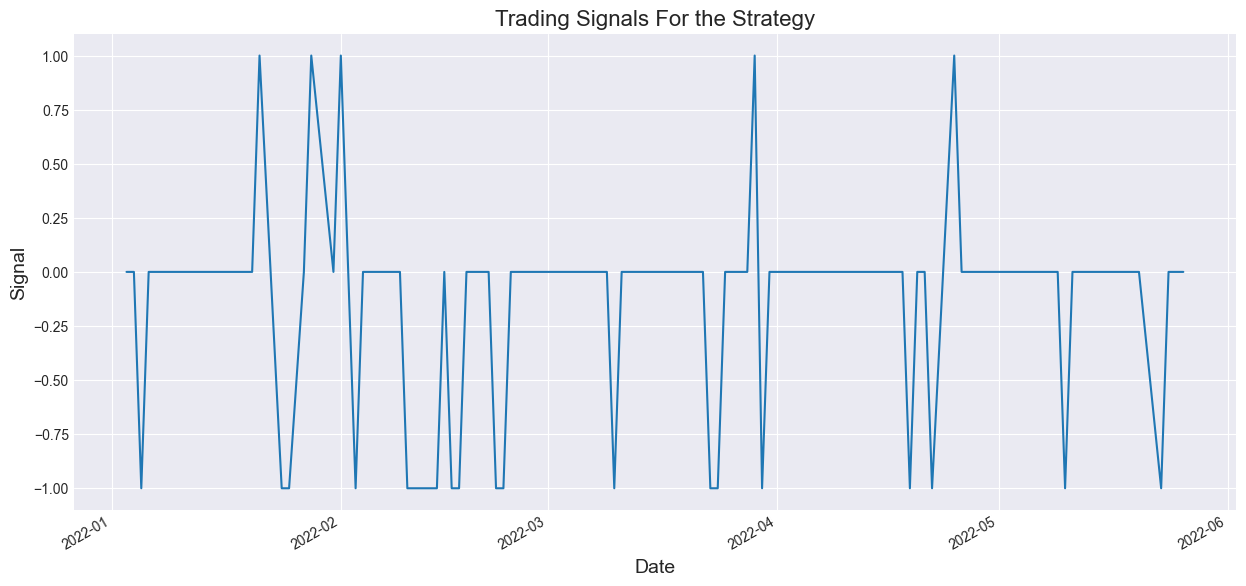

In [17]:
# Generate the long entry and exit signals
futures_data['long_signal'] = np.where(
    futures_data['volatility_skew'] < -0.05, 1, 0)

# Generate the short entry and exit signals
futures_data['short_signal'] = np.where(
    futures_data['volatility_skew'] > 0.1, -1, 0)

# Generate final signals
futures_data['signal'] = futures_data['long_signal'] + \
    futures_data['short_signal']

# Set signal to 0 on expiry since we will not take any position on expiry
futures_data.loc[futures_data.index == futures_data.Expiry, 'signal'] = 0

# Set figure size
plt.figure(figsize=(15, 7))

# Plot final signals
futures_data['signal'].plot()

# Set the title and axis labels
plt.title('Trading Signals For the Strategy', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Signal', fontsize=14)

# Display the chart
plt.show()

<a id='returns'></a>
## Analyse Strategy Performance 

To analyse the performance of the strategy, we will calculate the strategy returns and also compute the Sharpe ratio and maximum drawdown. 

To calculate the returns generated by the strategy, we will multiply the percentage change in futures close price by the signal. To calculate the compounded returns of the strategy, we will calculate the cumulative product of the returns by using the `np.cumprod` method. 

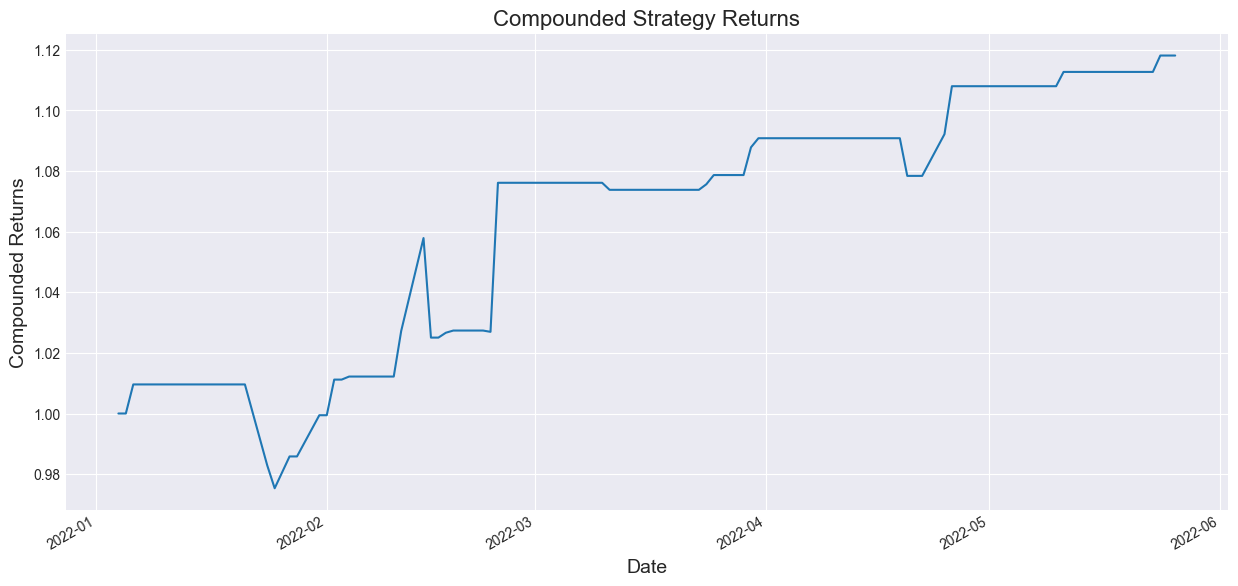

In [ ]:
# Calculate strategy returns
futures_data['strategy_returns'] = futures_data.futures_close.pct_change(
)*futures_data.signal.shift(1)

# Calculate compounded strategy returns
futures_data['compounded_strategy_returns'] = (
    futures_data['strategy_returns']+1).cumprod()

# Set figure size
plt.figure(figsize=(15, 7))

# Plot final signals
futures_data['compounded_strategy_returns'].plot()

# Set the title and axis labels
plt.title('Equity Curve', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Compounded Returns', fontsize=14)

# Display the chart
plt.show()

### Calculate the Annualized Sharpe Ratio

SR = Daily Mean / Daily Std * Sqrt(252)

In [19]:
# Calculate Sharpe ratio
sharpe_ratio = futures_data['strategy_returns'].mean(
)/futures_data['strategy_returns'].std()*252**0.5

# Print the value of Sharpe ratio
f"The Sharpe ratio is {sharpe_ratio:.2f}"

'The Sharpe ratio is 2.37'

### Calculate Maximum Drawdown

<Axes: xlabel='Date'>

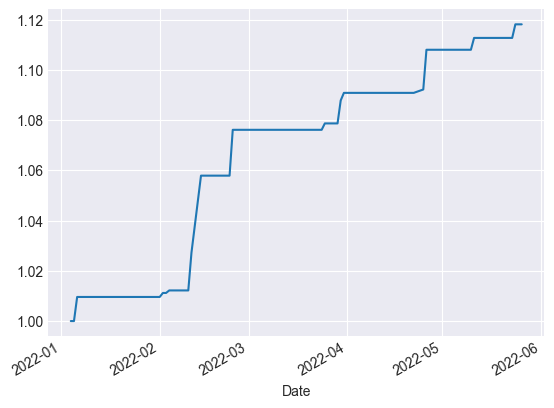

In [24]:
futures_data['compounded_strategy_returns'].cummax().plot()

<Axes: xlabel='Date'>

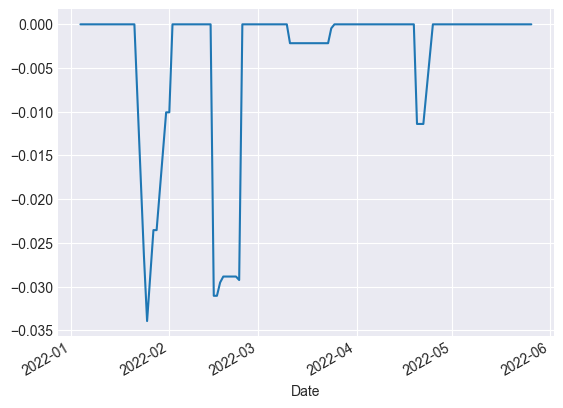

In [25]:
futures_data['Drawdown'] = (futures_data['compounded_strategy_returns'] / futures_data['compounded_strategy_returns'].cummax()) - 1
futures_data['Drawdown'].plot()


The maximum drawdown is -3.39%


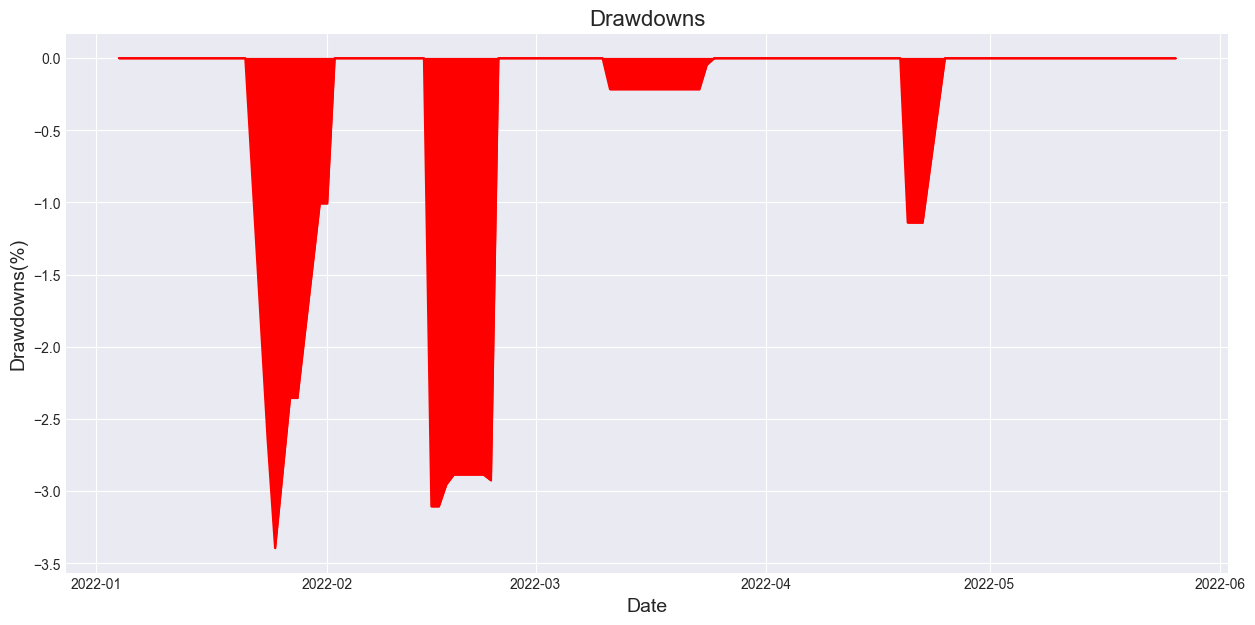

In [ ]:
# Compute the drawdown
futures_data['Drawdown'] =((futures_data['compounded_strategy_returns'] / futures_data['compounded_strategy_returns'].cummax()) - 1) * 100

# Compute the maximum drawdown
max_drawdown = (futures_data['Drawdown'].min())

# Print the value of maximum drawdown
print(f"The maximum drawdown is {max_drawdown:.2f}%")

# Define size of graph
plt.figure(figsize=(15, 7))

# Set the title and axis labels
plt.title('Drawdowns', fontsize=16)
plt.ylabel('Drawdowns(%)', fontsize=14)
plt.xlabel('Date', fontsize=14)

# Plot maximum drawdown
plt.plot(futures_data['Drawdown'], color='red')

# Fill in-between the drawdowns
plt.fill_between(futures_data['Drawdown'].index,
                 futures_data['Drawdown'].values, color='red')

# Display the chart
plt.show()

<a id='conclusion'></a>
## Conclusion
<br>
1) The compounded return generated by the strategy is approximately 1.12 times the initial capital. This means that if in January 2022, you had invested 1 dollar in this strategy and reinvested the profits, it would have increased to approximately  1.12 dollars by May 2022. 
<br>

2) The Sharpe ratio of the strategy comes out to be 2.37, which means to gain 2.37 dollars, you are risking 1 dollar. Generally, a Sharpe ratio greater than 1 implies that it is a good strategy. 
<br>

3) The maximum drawdown comes out to be -3.39%. This means you can expect to lose a maximum of around 3.39% when trading with this strategy. 
<br>

Let's recap!

In this notebook, we learned how to calculate the volatility skew. We created a long-short strategy based on volatility skew and analysed the returns generated by this strategy.  

In the upcoming video unit, we will recap what we learned in this section.  
<br><br>